In [41]:
!pip install pandas

In [1]:
import os
from pyspark import SparkContext,  SparkConf
from pyspark.sql import SparkSession
import findspark
import numpy as np
import pyspark
import pandas as pd
import matplotlib.pyplot as plt
import time 
import sys

### PRACTICAL ASSESSMENT TASK 2

#### 1. IMPLEMENTATION OF SERIALIZED K-MEANS (1 point)

serialReadFile: It receives a String filename Pandas dataframe with the loaded data.
with name of the csv file of the dataset. The function returns a

serialAssign2cluster: It receives a list of d-dimensional tuples called centroids, representing the current state
of the centroids, and a d-dimensional tuple x which represents the datum to be assigned to a cluster. It returns an
integer with the index in centroids of the closest centroid to x.
    
serialKMeans: Performs the serialized K-Means algorithm on the dataset X, grouping the instances into K different
clusters. The number of iterations of the method to be executed is n_iter. The initialization of the centroids will be
random, sampled from a standard normal distribution. It returns a list of length K with the d-dimensional centroids
computed.

In [4]:
# serial k-means from scratch

def serialReadFile(filename):
    data = pd.read_csv(filename)
    X = data.iloc[:, 1:]
    y = data['label']
    return X, y

def serialAssign2cluster(x, centroids):
    # Computes squared Euclidean distance and returns the index of the closest centroid.
    squared_distances = np.sum((x - centroids)**2, axis=1)
    return np.argmin(squared_distances)
        
    return index

def serialKMeans(X, K, n_iter):
    # Performs the serialized K-Means algorithm.
    X_array = X.values 
    n_samples, n_features = X_array.shape

    # Initialize centroids as a 2D NumPy array from standard normal distribution.
    centroids = np.random.randn(K, n_features)
    labels = np.zeros(n_samples, dtype=int)
    
    for iteration in range(n_iter):
        
        # Assignment Step: Assign each point to its closest cluster.
        for i in range(n_samples):
            labels[i] = serialAssign2cluster(X_array[i], centroids)
        
        # Centroid Update Step
        new_centroids = np.zeros_like(centroids)
        
        for k in range(K):
            cluster_points = X_array[labels == k]
            
            if cluster_points.shape[0] > 0:
                # Recalculate mean
                new_centroids[k] = cluster_points.mean(axis=0)
            else:
                # Handle empty cluster: reinitialize with a random data point.
                random_index = np.random.randint(n_samples)
                new_centroids[k] = X_array[random_index]

        # Convergence Check: stop if centroids haven't changed significantly.
        if np.allclose(centroids, new_centroids):
            print(f"Converged at iteration {iteration + 1}.")
            centroids = new_centroids
            break
            
        centroids = new_centroids
    
    # Return a list of length K with the d-dimensional centroids computed.
    return [tuple(c) for c in centroids]

In [21]:
def plot_centroids(centroids, title="K-Means Centroids"):
    """
    Plots the given centroids by reshaping them into 28x28 images.

    :param centroids: A list or array of K-dimensional centroids (each must be 784 elements long).
    :param title: The title for the overall plot.
    """
    K = len(centroids)
    grid_size = int(np.ceil(np.sqrt(K)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    axes = axes.flatten() # Flatten the 2D array of axes for easy indexing

    for i, centroid in enumerate(centroids):
        if i < K:
            image = np.array(centroid).reshape(28, 28)
            axes[i].imshow(image, cmap='gray')
            axes[i].set_title(f'Cluster {i}')
            axes[i].axis('off') # Hide axes ticks for cleaner image display
        else:
            # Hide unused subplots if K is not a perfect square
            axes[i].axis('off')

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show() # Use this locally in your Jupyter Notebook

#### 2. IMPLEMENTATION OF PARALLELIZED K-MEANS (4 points)

parallelReadFile: It receives a String filename with name of the csv file of the dataset. The function returns a
Spark RDD with the loaded data.

parallelAssign2cluster: It receives a list of d-dimensional tuples called centroids, representing the current
state of the centroids, and a d-dimensional tuple x which represents the datum to be assigned to a cluster. It returns
an integer with the index in centroids of the closest centroid to x.

parallelKMeans: Performs the parallelized K-Means algorithm on the RDD dataset data, grouping the
instances into K different clusters. The number of iterations of the method to be executed is n_iter. The
initialization of the centroids will be random, sampled from a standard normal distribution. It returns a list of
length K with the d-dimensional centroids computed.

In [2]:
def convert_to_numpy(line):
    return np.asarray([float(x) for x in line.split(",")[1:]], dtype=np.float32)

def parallelReadFile(filename, n_part, sc):
    data = sc.textFile(filename)

    # Removing the header the header line:
    header = data.first()
    data_no_header = data.filter(lambda line: line != header)

    # Repartition the data to exactly n partitions
    repartitioned_data = data_no_header.repartition(n_part)
    
    # Map data to NumPy arrays for numerical efficiency
    processed_data = repartitioned_data.map(convert_to_numpy)

    return processed_data

In [3]:
# same of serialAssignToCluster
def parallelAssign2cluster(x, centroids):
    squared_distances = np.sum((x - centroids)**2, axis=1)
    return np.argmin(squared_distances)

In [4]:
def parallelKMeans(X_rdd, K, n_iter, sc, tol=1e-4):
    """
    Performs the parallelized K-Means algorithm on the RDD dataset.

    :param X_rdd: RDD, The dataset of NumPy array points.
    :param K: int, number of clusters.
    :param n_iter: int, number of iterations.
    :return: list, list of K d-dimensional centroids (as tuples).
    """
    
    num_features = len(X_rdd.first())

    # Random initialization of centroids (2D NumPy array)
    centroids = np.random.randn(K, num_features)
    
    for iteration in range(n_iter):
        
        # Broadcast current centroids to all worker nodes
        bc_centroids = sc.broadcast(centroids)
        
        # 1. Assignment Step (Map): Point to (centroidID, (point, 1)) 
        cluster_assignment = X_rdd.map(
            lambda point: (
                parallelAssign2cluster(point, bc_centroids.value),  # Uses the parallel/util function
                (point, 1) # Value is (point_vector, count=1)
            )
        )
        
        # 2. Aggregation Step (Reduce): Sum points and counts per key (centroidID)
        cluster_stats = cluster_assignment.reduceByKey(
            lambda a, b: (a[0] + b[0], a[1] + b[1])
        ).collect() # Collect the results back to the driver
        
        # Clean up the old broadcast variable
        bc_centroids.unpersist() # spostare sotto per Pietro

        # 3. Recalculation Step (Driver): Compute new centroids
        new_centroids = np.zeros_like(centroids)
        assigned_clusters = set()

        for cluster_id, (point_sum, count) in cluster_stats: # provare a parallelizzare
            new_centroids[cluster_id] = point_sum / count
            assigned_clusters.add(cluster_id)
            
        # Handle empty clusters: reinitialize with a random point from a standard normal distribution
        for k in range(K):
            if k not in assigned_clusters:
                # Reinitialize empty cluster from standard normal distribution
                new_centroids[k] = np.random.randn(num_features)
        
        # Convergence Check
        if np.allclose(centroids, new_centroids, atol=tol):
            print(f"Converged at iteration {iteration + 1}.")
            centroids = new_centroids
            break
            
        centroids = new_centroids

    # Final result: Return centroids as a list of d-dimensional tuples 
    return [tuple(c) for c in centroids]

In [33]:
RDD = parallelReadFile('mnist_dataset.csv', 8, sc)
start_time = time.time()
centroids_parallelized = parallelKMeans(RDD, 10, 10, sc)
print("time required: ", time.time() - start_time)

[Stage 37:>                                                         (0 + 8) / 8]

time required:  30.508108377456665


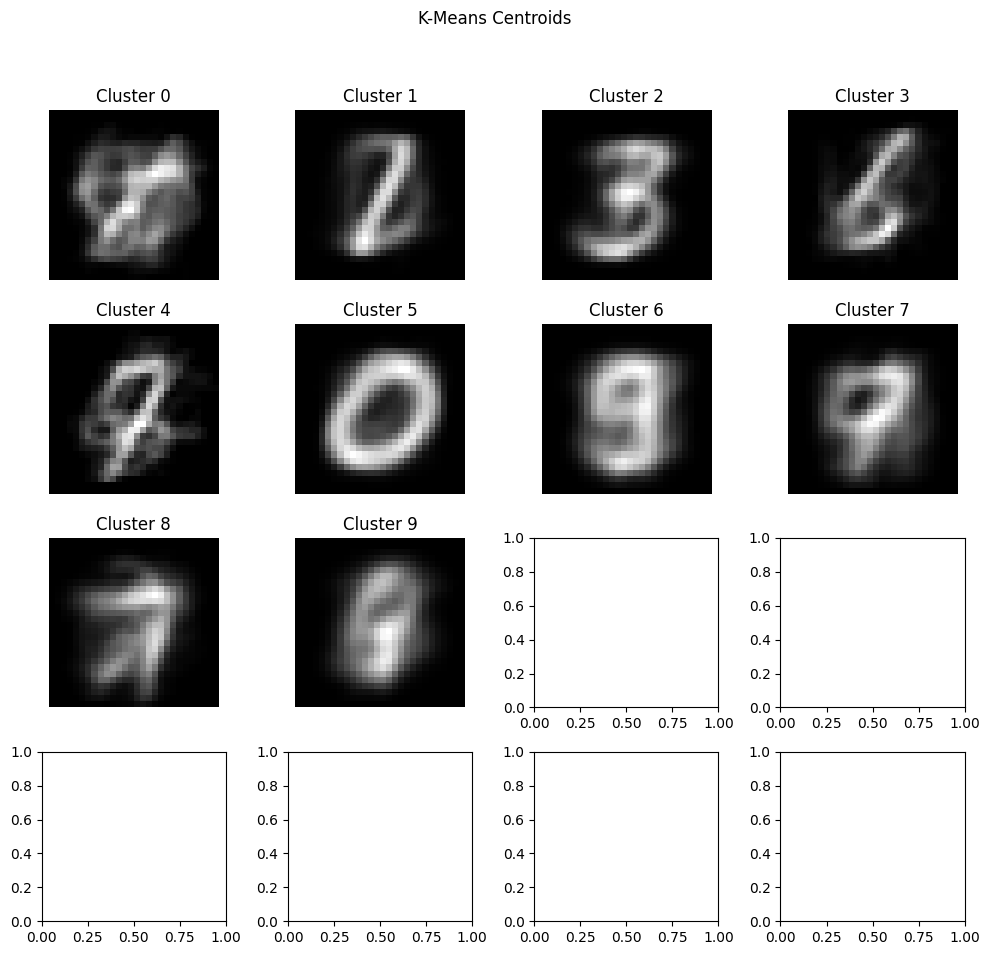

In [22]:
plot_centroids(centroids_parallelized)

#### 3. ANALYSIS AND DISCUSSION (5 points)
Using the aforementioned version of the parallelized K-Means algorithm, analyze the execution time of the
proposed solution on the MNIST dataset uploaded to Moodle. This dataset contains 70,000 samples of handwritten
digits, from 0 to 9. Each image is represented by a 28 × 28 matrix of black-and-white pixels. In the dataset, this pixel
matrix has been flattened into a 28 × 28 = 784 vector, so the dataset contains 28000 rows and 784 columns. Each pixel
is represented by an integer ranging from 0 (white pixel) to 255 (black pixel).

In [24]:
# Cleanup at the start of each experiment
try:
    data_cache.unpersist()
    sc.stop()
    print("SparkContext stopped successfully")
except:
    pass

#-------- Settings -------------------------

CORE_COUNTS = [1, 2, 4, 8, 9, 10, 12]  # Example core counts to test
K_VALUES = [3, 5, 10, 20]              # Example K values (you should test more)
N_ITER = 5                         # Fixed number of iterations

# Dictionary to store results: {K_value: {num_cores: execution_time}}
execution_times_3_1 = {K: {} for K in K_VALUES}
speedups_3_1 = {K: {} for K in K_VALUES}

# Set environment variables for consistent Python interpreter use
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

# --- Main Performance Measurement Loop ---

for K in K_VALUES:
    
    # Inner loop over number of cores (workers)
    for number_cores in CORE_COUNTS:
        
        # Stop any existing context
        try:
            pyspark.SparkContext._active_spark_context.stop()
        except:
            pass
            
        conf = (
            pyspark.SparkConf()
            .setMaster(f'local[{number_cores}]')
            .setAppName(f'KMeans_K{K}_{number_cores}_cores')
            .set("spark.default.parallelism", str(number_cores)) # Set default parallelism equal to cores
        )
        
        sc = pyspark.SparkContext(conf=conf)
        
        # --- Data Loading and Caching ---
        data = parallelReadFile('mnist_dataset.csv', number_cores, sc)
        data_cache = data.cache()
        data_cache.count()

        # --- Execution and Timing ---
        start_time = time.time()
        
        # Run K-Means
        centroids = parallelKMeans(data_cache, K, N_ITER, sc)
        
        end_time = time.time()
        
        execution_time = end_time - start_time
        execution_times_3_1[K][number_cores] = execution_time
        
        print(f"K={K}, Cores={number_cores}: Time={execution_time:.4f}s")
        
        # Cleanup 
        data_cache.unpersist()
        sc.stop()
        time.sleep(1) # Give Spark time to shut down resources

    # --- Speedup Calculation (After all core runs for a given K) ---
    T_serial = execution_times_3_1[K][1] # Time taken by 1 worker (T1) is the baseline
    
    for number_cores in CORE_COUNTS:
        T_n = execution_times_3_1[K][number_cores]
        S_n = T_serial / T_n
        speedups_3_1[K][number_cores] = S_n

    print(f"Times: {execution_times_3_1[K]}")
    print(f"Speedup: {speedups_3_1[K]}")
    print("---------------------\n")

# --- Final Output (Use these dictionaries for plotting) ---
print("\nFINAL EXECUTION TIMES:")
print(execution_times_3_1)
print("\nFINAL SPEEDUP RATIOS:")
print(speedups_3_1)


25/12/09 16:53:56 WARN BlockManager: Task 6 already completed, not releasing lock for rdd_8_0
                                                                                

K=3, Cores=1: Time=14.0658s


25/12/09 16:54:23 WARN BlockManager: Task 7 already completed, not releasing lock for rdd_8_0
                                                                                

K=3, Cores=2: Time=11.9353s


25/12/09 16:54:42 WARN BlockManager: Task 9 already completed, not releasing lock for rdd_8_0
                                                                                

K=3, Cores=4: Time=6.7875s


25/12/09 16:54:55 WARN BlockManager: Task 13 already completed, not releasing lock for rdd_8_0
                                                                                

K=3, Cores=8: Time=5.3315s


25/12/09 16:55:07 WARN BlockManager: Task 14 already completed, not releasing lock for rdd_8_0
                                                                                

K=3, Cores=9: Time=6.3631s


25/12/09 16:55:21 WARN BlockManager: Task 15 already completed, not releasing lock for rdd_8_0
                                                                                

K=3, Cores=10: Time=6.4168s


25/12/09 16:55:35 WARN BlockManager: Task 17 already completed, not releasing lock for rdd_8_0
                                                                                

K=3, Cores=12: Time=8.3563s
Times: {1: 14.065797090530396, 2: 11.935310363769531, 4: 6.787475824356079, 8: 5.3314595222473145, 9: 6.363084077835083, 10: 6.4168479442596436, 12: 8.356315851211548}
Speedup: {1: 1.0, 2: 1.1785028341808443, 4: 2.0723163447679465, 8: 2.6382638809947085, 9: 2.2105313898847636, 10: 2.1920103472474075, 12: 1.6832534026931323}
---------------------



25/12/09 16:55:57 WARN BlockManager: Task 6 already completed, not releasing lock for rdd_8_0
                                                                                

K=5, Cores=1: Time=19.5380s


25/12/09 16:56:24 WARN BlockManager: Task 7 already completed, not releasing lock for rdd_8_0
                                                                                

K=5, Cores=2: Time=10.3977s


25/12/09 16:56:41 WARN BlockManager: Task 9 already completed, not releasing lock for rdd_8_0
                                                                                

K=5, Cores=4: Time=5.9765s


25/12/09 16:56:54 WARN BlockManager: Task 13 already completed, not releasing lock for rdd_8_0
                                                                                

K=5, Cores=8: Time=5.8920s


25/12/09 16:57:06 WARN BlockManager: Task 14 already completed, not releasing lock for rdd_8_0
                                                                                

K=5, Cores=9: Time=6.3528s


25/12/09 16:57:19 WARN BlockManager: Task 15 already completed, not releasing lock for rdd_8_0
                                                                                

K=5, Cores=10: Time=6.3894s


25/12/09 16:57:33 WARN BlockManager: Task 17 already completed, not releasing lock for rdd_8_0
                                                                                

K=5, Cores=12: Time=7.4275s
Times: {1: 19.537988424301147, 2: 10.397698879241943, 4: 5.976506471633911, 8: 5.892003059387207, 9: 6.352822780609131, 10: 6.389392137527466, 12: 7.427479028701782}
Speedup: {1: 1.0, 2: 1.8790684988297706, 4: 3.269131978193889, 8: 3.316018037901898, 9: 3.0754814196828226, 10: 3.0578790601294754, 12: 2.6305006515401916}
---------------------



25/12/09 16:57:53 WARN BlockManager: Task 6 already completed, not releasing lock for rdd_8_0
                                                                                

K=10, Cores=1: Time=31.4848s


25/12/09 16:58:33 WARN BlockManager: Task 7 already completed, not releasing lock for rdd_8_0
                                                                                

K=10, Cores=2: Time=16.2233s


25/12/09 16:58:56 WARN BlockManager: Task 9 already completed, not releasing lock for rdd_8_0
                                                                                

K=10, Cores=4: Time=9.1383s


25/12/09 16:59:12 WARN BlockManager: Task 13 already completed, not releasing lock for rdd_8_0
                                                                                

K=10, Cores=8: Time=5.7849s


25/12/09 16:59:24 WARN BlockManager: Task 14 already completed, not releasing lock for rdd_8_0
                                                                                

K=10, Cores=9: Time=7.1492s


25/12/09 16:59:38 WARN BlockManager: Task 15 already completed, not releasing lock for rdd_8_0
                                                                                

K=10, Cores=10: Time=7.0573s


25/12/09 16:59:52 WARN BlockManager: Task 17 already completed, not releasing lock for rdd_8_0
                                                                                

K=10, Cores=12: Time=8.1990s
Times: {1: 31.484800815582275, 2: 16.223284482955933, 4: 9.138322591781616, 8: 5.784866809844971, 9: 7.149162769317627, 10: 7.057296514511108, 12: 8.198967456817627}
Speedup: {1: 1.0, 2: 1.9407168042118712, 4: 3.4453588718675303, 8: 5.442614644472003, 9: 4.403984330963476, 10: 4.461311884918494, 12: 3.8400933997368107}
---------------------



25/12/09 17:00:13 WARN BlockManager: Task 6 already completed, not releasing lock for rdd_8_0
                                                                                

K=20, Cores=1: Time=56.0155s


25/12/09 17:01:17 WARN BlockManager: Task 7 already completed, not releasing lock for rdd_8_0
                                                                                

K=20, Cores=2: Time=28.4871s


25/12/09 17:01:52 WARN BlockManager: Task 9 already completed, not releasing lock for rdd_8_0
                                                                                

K=20, Cores=4: Time=15.1102s


25/12/09 17:02:14 WARN BlockManager: Task 13 already completed, not releasing lock for rdd_8_0
                                                                                

K=20, Cores=8: Time=7.8242s


25/12/09 17:02:29 WARN BlockManager: Task 14 already completed, not releasing lock for rdd_8_0
                                                                                

K=20, Cores=9: Time=9.2513s


25/12/09 17:02:45 WARN BlockManager: Task 15 already completed, not releasing lock for rdd_8_0
                                                                                

K=20, Cores=10: Time=9.7700s


25/12/09 17:03:06 WARN BlockManager: Task 17 already completed, not releasing lock for rdd_8_0
                                                                                

K=20, Cores=12: Time=32.2856s
Times: {1: 56.01546335220337, 2: 28.48705792427063, 4: 15.110217094421387, 8: 7.824165344238281, 9: 9.251322984695435, 10: 9.769987106323242, 12: 32.28556203842163}
Speedup: {1: 1.0, 2: 1.966347788568186, 4: 3.7071249871640815, 8: 7.159289315562992, 9: 6.054859769231965, 10: 5.73342244392007, 12: 1.7350004093328721}
---------------------


FINAL EXECUTION TIMES:
{3: {1: 14.065797090530396, 2: 11.935310363769531, 4: 6.787475824356079, 8: 5.3314595222473145, 9: 6.363084077835083, 10: 6.4168479442596436, 12: 8.356315851211548}, 5: {1: 19.537988424301147, 2: 10.397698879241943, 4: 5.976506471633911, 8: 5.892003059387207, 9: 6.352822780609131, 10: 6.389392137527466, 12: 7.427479028701782}, 10: {1: 31.484800815582275, 2: 16.223284482955933, 4: 9.138322591781616, 8: 5.784866809844971, 9: 7.149162769317627, 10: 7.057296514511108, 12: 8.198967456817627}, 20: {1: 56.01546335220337, 2: 28.48705792427063, 4: 15.110217094421387, 8: 7.824165344238281, 9: 9.2513229846954

3.1 (2 points) Study the execution time of the K-Means algorithm on the MNIST dataset versus the number of
parallel workers and prepare plots showing:
(i) The performance curve (the execution time (y axis) versus the number of workers (x axis) using different
values of K.
(ii) The speedup ratio (running time using

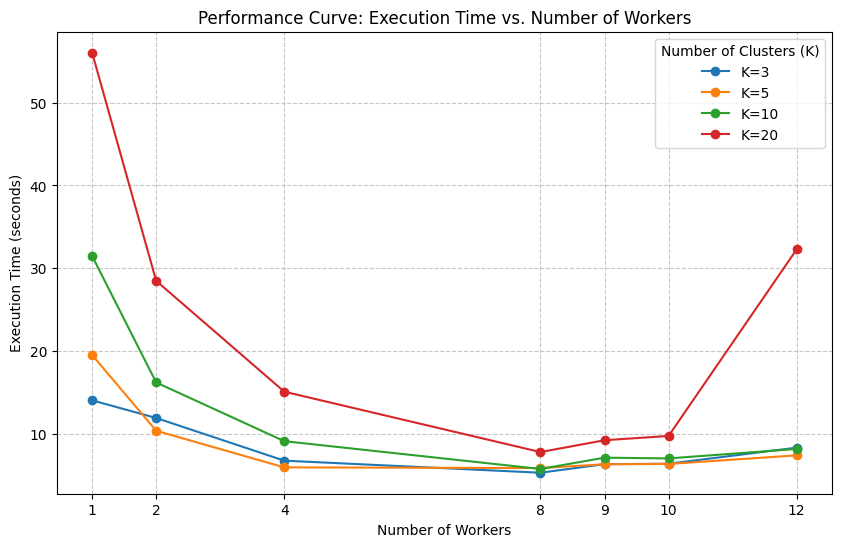

In [25]:
plt.figure(figsize=(10, 6))
    
# Iterate through each K value in the results
for K, times in execution_times_3_1.items():
    # Keys are number of cores (X-axis), Values are execution times (Y-axis)
    cores = sorted(times.keys())
    times_list = [times[c] for c in cores]
    
    plt.plot(cores, times_list, marker='o', label=f'K={K}')

plt.title('Performance Curve: Execution Time vs. Number of Workers')
plt.xlabel('Number of Workers')
plt.ylabel('Execution Time (seconds)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Number of Clusters (K)')
plt.xticks(cores)  # Ensure x-axis ticks match the core counts tested
plt.show()

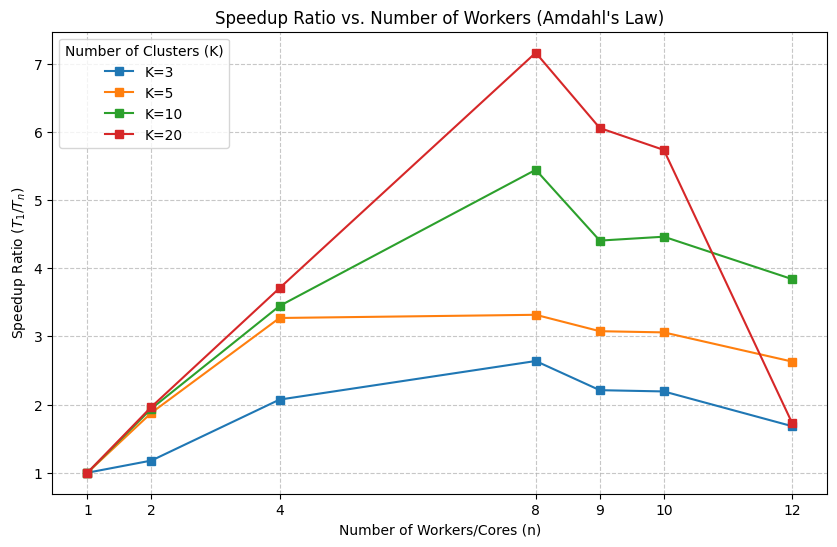

In [26]:
plt.figure(figsize=(10, 6))
    
# Iterate through each K value in the speedup data
for K, ratios in speedups_3_1.items():
    cores = sorted(ratios.keys())
    ratios_list = [ratios[c] for c in cores]
    
    plt.plot(cores, ratios_list, marker='s', label=f'K={K}')

plt.title('Speedup Ratio vs. Number of Workers (Amdahl\'s Law)')
plt.xlabel('Number of Workers/Cores (n)')
plt.ylabel('Speedup Ratio ($T_1 / T_n$)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Number of Clusters (K)')
plt.xticks(cores)
plt.show()

3.2 (1 point) Analyze the impact of parallelizing other parts of the algorithm as the computations of distances of an
instance to each of the centroids. Plot the performance and speedup curves using different values of K and compare the
results with respect the ones obtained in 3.1

In [27]:
# Naive approach
def naive_parallelAssign2cluster(x, centroids):
    """
    Naive version using an explicit Python for loop to find the minimum distance.
    (Corrected distance calculation)
    """
    K = centroids.shape[0]
    min_val = np.inf
    c_min = -1
    
    # Explicit linear search over K centroids
    for i in range(K):
        # Calculate the distance between the point x and the i-th centroid
        # Corrected: Difference, squared, summed, then square root
        d = np.sqrt(np.sum((x - centroids[i])**2)) 
        
        if d < min_val:
            c_min = i
            min_val = d
            
    return c_min
    

In [19]:
def naive_parallelKMeans(X_rdd, K, n_iter, sc, tol=1e-4):
    """
    Performs the parallelized K-Means algorithm on the RDD dataset.

    :param X_rdd: RDD, The dataset of NumPy array points.
    :param K: int, number of clusters.
    :param n_iter: int, number of iterations.
    :return: list, list of K d-dimensional centroids (as tuples).
    """
    
    num_features = len(X_rdd.first())

    # Random initialization of centroids (2D NumPy array)
    centroids = np.random.randn(K, num_features)
    
    for iteration in range(n_iter):
        
        # Broadcast current centroids to all worker nodes
        bc_centroids = sc.broadcast(centroids)
        
        # 1. Assignment Step (Map): Point to (centroidID, (point, 1)) 
        cluster_assignment = X_rdd.map(
            lambda point: (
                naive_parallelAssign2cluster(point, bc_centroids.value),  # Uses the parallel/util function
                (point, 1) # Value is (point_vector, count=1)
            )
        )
        
        # 2. Aggregation Step (Reduce): Sum points and counts per key (centroidID)
        cluster_stats = cluster_assignment.reduceByKey(
            lambda a, b: (a[0] + b[0], a[1] + b[1])
        ).collect() # Collect the results back to the driver
        
        # Clean up the old broadcast variable
        bc_centroids.unpersist() # spostare sotto per Pietro

        # 3. Recalculation Step (Driver): Compute new centroids
        new_centroids = np.zeros_like(centroids)
        assigned_clusters = set()

        for cluster_id, (point_sum, count) in cluster_stats: # provare a parallelizzare
            new_centroids[cluster_id] = point_sum / count
            assigned_clusters.add(cluster_id)
            
        # Handle empty clusters: reinitialize with a random point from a standard normal distribution
        for k in range(K):
            if k not in assigned_clusters:
                # Reinitialize empty cluster from standard normal distribution
                new_centroids[k] = np.random.randn(num_features)
        
        # Convergence Check
        if np.allclose(centroids, new_centroids, atol=tol):
            print(f"Converged at iteration {iteration + 1}.")
            centroids = new_centroids
            break
            
        centroids = new_centroids

    # Final result: Return centroids as a list of d-dimensional tuples 
    return [tuple(c) for c in centroids]

In [28]:
# Cleanup at the start of each experiment
try:
    data_cache.unpersist()
    sc.stop()
    print("SparkContext stopped successfully")
except:
    pass


CORE_COUNTS = [1, 2, 4, 8, 9, 10, 12]  # Example core counts to test
K_VALUES = [3, 5, 10, 20]              # Example K values (you should test more)
N_ITER = 5                         # Fixed number of iterations

# Dictionary to store results: {K_value: {num_cores: execution_time}}
execution_times_naive = {K: {} for K in K_VALUES}
speedups_naive = {K: {} for K in K_VALUES}

# Set environment variables for consistent Python interpreter use
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

# --- Main Performance Measurement Loop ---

for K in K_VALUES:
    
    # Inner loop over number of cores (workers)
    for number_cores in CORE_COUNTS:
        
        # Stop any existing context
        try:
            pyspark.SparkContext._active_spark_context.stop()
        except:
            pass
            
        conf = (
            pyspark.SparkConf()
            .setMaster(f'local[{number_cores}]')
            .setAppName(f'KMeans_K{K}_{number_cores}_cores')
            .set("spark.default.parallelism", str(number_cores)) # Set default parallelism equal to cores
        )
        
        sc = pyspark.SparkContext(conf=conf)
        
        # --- Data Loading and Caching ---
        data = parallelReadFile('mnist_dataset.csv', number_cores, sc)
        data_cache = data.cache()
        data_cache.count()

        # --- Execution and Timing ---
        start_time = time.time()
        
        # Run K-Means
        centroids = naive_parallelKMeans(data_cache, K, N_ITER, sc)
        
        end_time = time.time()
        
        execution_time = end_time - start_time
        execution_times_naive[K][number_cores] = execution_time
        
        print(f"K={K}, Cores={number_cores}: Time={execution_time:.4f}s")
        
        # Cleanup 
        data_cache.unpersist()
        sc.stop()
        time.sleep(1) # Give Spark time to shut down resources

    # --- Speedup Calculation (After all core runs for a given K) ---
    T_serial = execution_times_naive[K][1] # Time taken by 1 worker (T1) is the baseline
    
    for number_cores in CORE_COUNTS:
        T_n = execution_times_naive[K][number_cores]
        S_n = T_serial / T_n
        speedups_naive[K][number_cores] = S_n

    print(f"Times: {execution_times_naive[K]}")
    print(f"Speedup: {speedups_naive[K]}")
    print("---------------------\n")

# --- Final Output (Use these dictionaries for plotting) ---
print("\nFINAL EXECUTION TIMES:")
print(execution_times_naive)
print("\nFINAL SPEEDUP RATIOS:")
print(speedups_naive)

25/12/09 17:14:29 WARN BlockManager: Task 6 already completed, not releasing lock for rdd_8_0
                                                                                

K=3, Cores=1: Time=19.9920s


25/12/09 17:15:00 WARN BlockManager: Task 7 already completed, not releasing lock for rdd_8_0
                                                                                

K=3, Cores=2: Time=11.7897s


25/12/09 17:15:20 WARN BlockManager: Task 9 already completed, not releasing lock for rdd_8_0
                                                                                

K=3, Cores=4: Time=7.9325s


25/12/09 17:15:35 WARN BlockManager: Task 13 already completed, not releasing lock for rdd_8_0
                                                                                

K=3, Cores=8: Time=10.1696s


25/12/09 17:15:52 WARN BlockManager: Task 14 already completed, not releasing lock for rdd_8_0
                                                                                

K=3, Cores=9: Time=7.1099s


25/12/09 17:16:05 WARN BlockManager: Task 15 already completed, not releasing lock for rdd_8_0
                                                                                

K=3, Cores=10: Time=6.9973s


25/12/09 17:16:21 WARN BlockManager: Task 17 already completed, not releasing lock for rdd_8_0
                                                                                

K=3, Cores=12: Time=9.0671s
Times: {1: 19.991997241973877, 2: 11.789698123931885, 4: 7.9325268268585205, 8: 10.169645547866821, 9: 7.1099114418029785, 10: 6.997252464294434, 12: 9.067109823226929}
Speedup: {1: 1.0, 2: 1.6957174841815637, 4: 2.520255862770427, 8: 1.9658499549345048, 9: 2.811848980907162, 10: 2.8571210405782845, 12: 2.204891926064578}
---------------------



25/12/09 17:16:43 WARN BlockManager: Task 6 already completed, not releasing lock for rdd_8_0
                                                                                

K=5, Cores=1: Time=28.4009s


25/12/09 17:17:20 WARN BlockManager: Task 7 already completed, not releasing lock for rdd_8_0
                                                                                

K=5, Cores=2: Time=15.0970s


25/12/09 17:17:43 WARN BlockManager: Task 9 already completed, not releasing lock for rdd_8_0
                                                                                

K=5, Cores=4: Time=9.2187s


25/12/09 17:18:00 WARN BlockManager: Task 13 already completed, not releasing lock for rdd_8_0
                                                                                

K=5, Cores=8: Time=9.9363s


25/12/09 17:18:17 WARN BlockManager: Task 14 already completed, not releasing lock for rdd_8_0
                                                                                

K=5, Cores=9: Time=9.3932s


25/12/09 17:18:34 WARN BlockManager: Task 15 already completed, not releasing lock for rdd_8_0
                                                                                

K=5, Cores=10: Time=10.3067s


25/12/09 17:18:51 WARN BlockManager: Task 17 already completed, not releasing lock for rdd_8_0
                                                                                

K=5, Cores=12: Time=11.3851s
Times: {1: 28.400854110717773, 2: 15.096951484680176, 4: 9.218651294708252, 8: 9.93629789352417, 9: 9.393225193023682, 10: 10.30665111541748, 12: 11.385071039199829}
Speedup: {1: 1.0, 2: 1.8812310643998493, 4: 3.0808036016093383, 8: 2.858293341751317, 9: 3.023546601630609, 10: 2.7555850870156644, 12: 2.4945697758873058}
---------------------



25/12/09 17:19:16 WARN BlockManager: Task 6 already completed, not releasing lock for rdd_8_0
                                                                                

K=10, Cores=1: Time=52.9248s


25/12/09 17:20:18 WARN BlockManager: Task 7 already completed, not releasing lock for rdd_8_0
                                                                                

K=10, Cores=2: Time=29.5620s


25/12/09 17:20:57 WARN BlockManager: Task 9 already completed, not releasing lock for rdd_8_0
                                                                                

K=10, Cores=4: Time=20.2771s


25/12/09 17:21:26 WARN BlockManager: Task 13 already completed, not releasing lock for rdd_8_0
                                                                                

K=10, Cores=8: Time=16.7017s


25/12/09 17:21:51 WARN BlockManager: Task 14 already completed, not releasing lock for rdd_8_0
                                                                                

K=10, Cores=9: Time=16.6927s


25/12/09 17:22:16 WARN BlockManager: Task 15 already completed, not releasing lock for rdd_8_0
                                                                                

K=10, Cores=10: Time=21.0222s


25/12/09 17:22:45 WARN BlockManager: Task 17 already completed, not releasing lock for rdd_8_0
                                                                                

K=10, Cores=12: Time=18.4709s
Times: {1: 52.92478346824646, 2: 29.561990976333618, 4: 20.27711510658264, 8: 16.701671838760376, 9: 16.692739486694336, 10: 21.022194385528564, 12: 18.470886707305908}
Speedup: {1: 1.0, 2: 1.7902983432549027, 4: 2.610074618112972, 8: 3.168831478620084, 9: 3.170527133094746, 10: 2.517567029285928, 12: 2.865308217569911}
---------------------



25/12/09 17:23:19 WARN BlockManager: Task 6 already completed, not releasing lock for rdd_8_0
                                                                                

K=20, Cores=1: Time=110.8125s


25/12/09 17:25:18 WARN BlockManager: Task 7 already completed, not releasing lock for rdd_8_0
                                                                                

K=20, Cores=2: Time=51.7104s


25/12/09 17:26:19 WARN BlockManager: Task 9 already completed, not releasing lock for rdd_8_0
                                                                                

K=20, Cores=4: Time=33.3997s


25/12/09 17:27:00 WARN BlockManager: Task 13 already completed, not releasing lock for rdd_8_0
                                                                                

K=20, Cores=8: Time=20.9321s


25/12/09 17:27:28 WARN BlockManager: Task 14 already completed, not releasing lock for rdd_8_0
                                                                                

K=20, Cores=9: Time=23.3035s


25/12/09 17:27:59 WARN BlockManager: Task 15 already completed, not releasing lock for rdd_8_0
                                                                                

K=20, Cores=10: Time=27.8561s


25/12/09 17:28:35 WARN BlockManager: Task 17 already completed, not releasing lock for rdd_8_0
                                                                                

K=20, Cores=12: Time=23.7101s
Times: {1: 110.81252217292786, 2: 51.710352659225464, 4: 33.39969873428345, 8: 20.932071685791016, 9: 23.303537845611572, 10: 27.85612416267395, 12: 23.71007776260376}
Speedup: {1: 1.0, 2: 2.1429465566245405, 4: 3.3177701108777744, 8: 5.293910886429313, 9: 4.755180218002634, 10: 3.978030882035342, 12: 4.673646509405577}
---------------------


FINAL EXECUTION TIMES:
{3: {1: 19.991997241973877, 2: 11.789698123931885, 4: 7.9325268268585205, 8: 10.169645547866821, 9: 7.1099114418029785, 10: 6.997252464294434, 12: 9.067109823226929}, 5: {1: 28.400854110717773, 2: 15.096951484680176, 4: 9.218651294708252, 8: 9.93629789352417, 9: 9.393225193023682, 10: 10.30665111541748, 12: 11.385071039199829}, 10: {1: 52.92478346824646, 2: 29.561990976333618, 4: 20.27711510658264, 8: 16.701671838760376, 9: 16.692739486694336, 10: 21.022194385528564, 12: 18.470886707305908}, 20: {1: 110.81252217292786, 2: 51.710352659225464, 4: 33.39969873428345, 8: 20.932071685791016, 9: 23.30

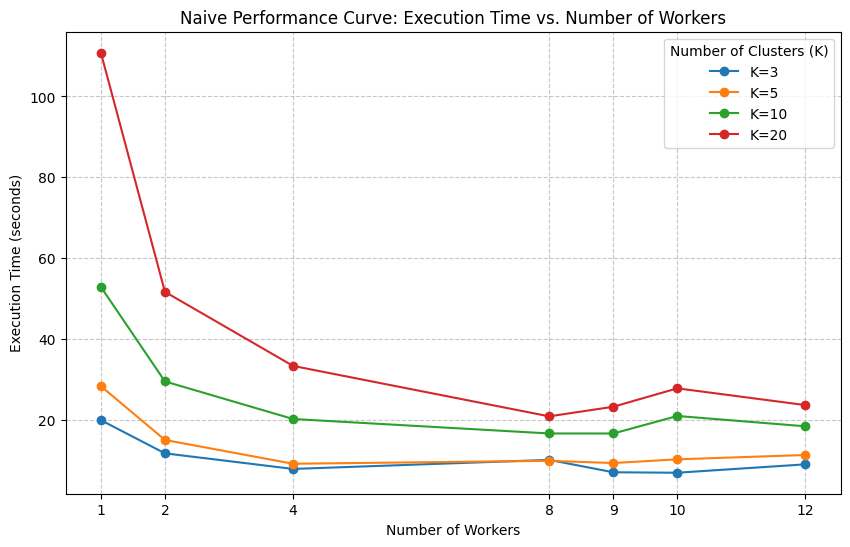

In [29]:
plt.figure(figsize=(10, 6))
    
# Iterate through each K value in the results
for K, times in execution_times_naive.items():
    # Keys are number of cores (X-axis), Values are execution times (Y-axis)
    cores = sorted(times.keys())
    times_list = [times[c] for c in cores]
    
    plt.plot(cores, times_list, marker='o', label=f'K={K}')

plt.title('Naive Performance Curve: Execution Time vs. Number of Workers')
plt.xlabel('Number of Workers')
plt.ylabel('Execution Time (seconds)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Number of Clusters (K)')
plt.xticks(cores)  # Ensure x-axis ticks match the core counts tested
plt.savefig('performance_curve.png')
plt.show()

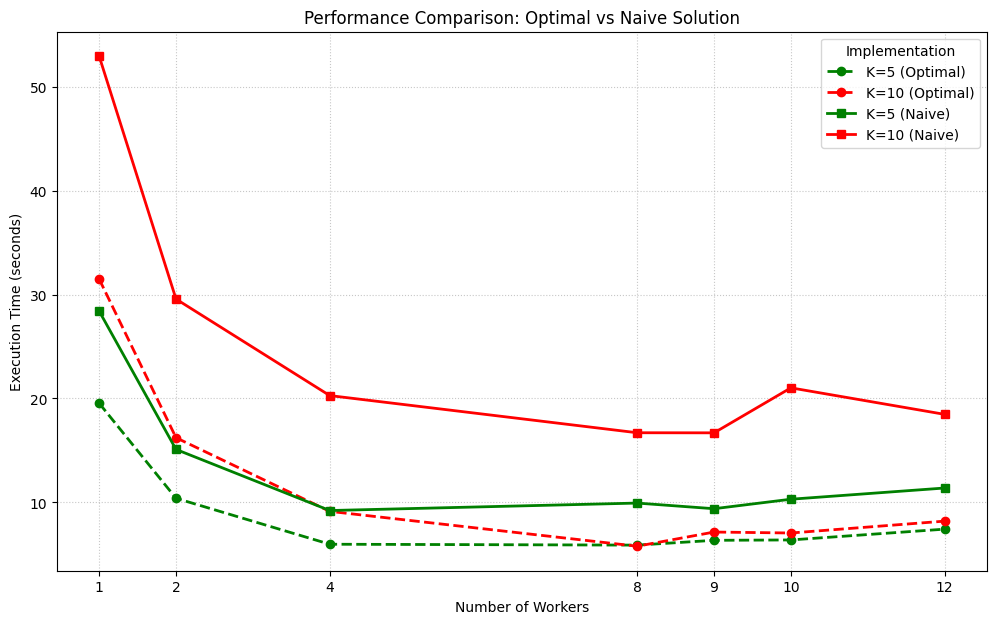

In [36]:
# SCENARIO A: comparison between Naive Solution and Optimal Solution with K<<100

plt.figure(figsize=(12, 7))
# Define colors for each K value
colors = {5: 'green', 10: 'red', 20: 'grey'}
# Plot optimal solution (dashed lines)
for K, times in execution_times_3_1.items():
    if K == 3 or K == 20:  # Skip K=3
        continue
    cores = sorted(times.keys())
    times_list = [times[c] for c in cores]
    
    plt.plot(cores, times_list, marker='o', linestyle='--', 
             color=colors[K], label=f'K={K} (Optimal)', linewidth=2)
# Plot naive solution (solid lines)
for K, times in execution_times_naive.items():
    if K == 3 or K == 20:  # Skip K=3
        continue
    cores = sorted(times.keys())
    times_list = [times[c] for c in cores]
    
    plt.plot(cores, times_list, marker='s', linestyle='-', 
             color=colors[K], label=f'K={K} (Naive)', linewidth=2)
plt.title('Performance Comparison: Optimal vs Naive Solution')
plt.xlabel('Number of Workers')
plt.ylabel('Execution Time (seconds)')
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(title='Implementation', loc='best')
plt.xticks(cores)
plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

3.3 (0.5 points) Analyze and interpret the obtained clusters with K = 3, 5, 7, 8, 9, 10 and 11. Show plots of the
obtained centroids and relate them with the original data.

25/12/07 13:39:35 WARN BlockManager: Task 13 already completed, not releasing lock for rdd_8_0


Running K-Means for K=3...
Time required: 4.95s


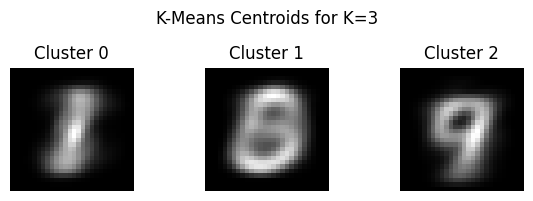

Running K-Means for K=5...


25/12/07 13:39:40 WARN BlockManager: Task 104 already completed, not releasing lock for rdd_8_0
                                                                                

Time required: 5.67s


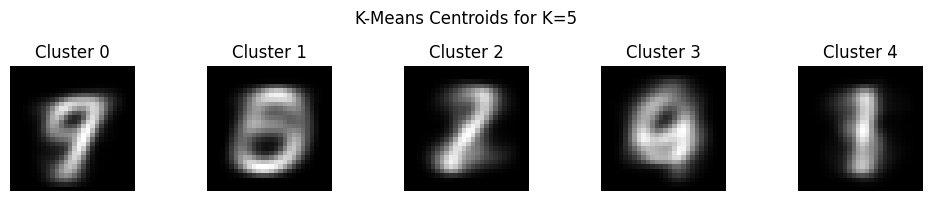

Running K-Means for K=7...


25/12/07 13:39:46 WARN BlockManager: Task 195 already completed, not releasing lock for rdd_8_0


Time required: 6.25s


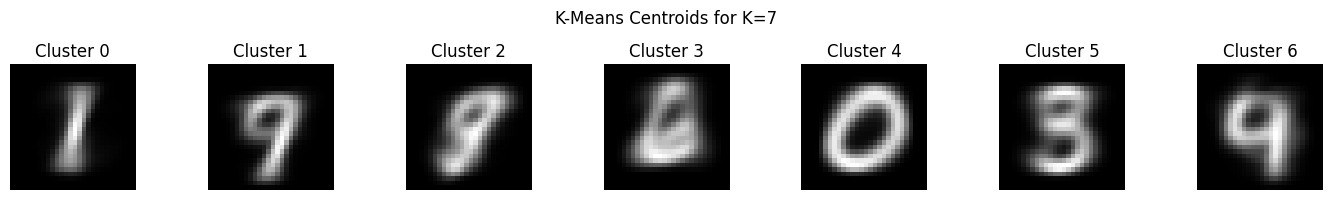

Running K-Means for K=8...


25/12/07 13:39:52 WARN BlockManager: Task 286 already completed, not releasing lock for rdd_8_0
                                                                                

Time required: 6.29s


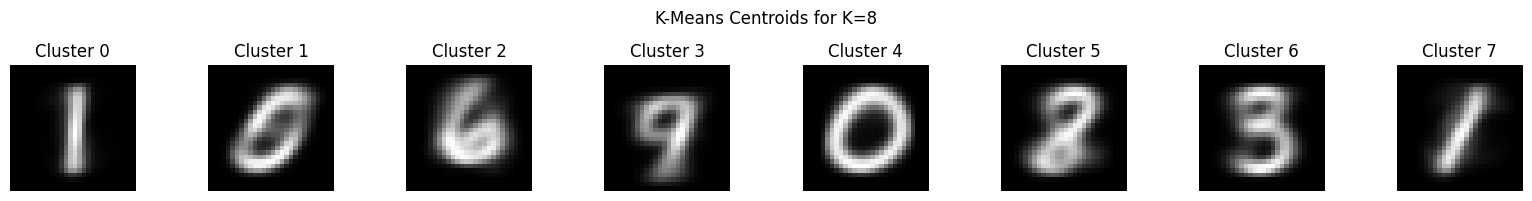

Running K-Means for K=9...


25/12/07 13:39:59 WARN BlockManager: Task 377 already completed, not releasing lock for rdd_8_0
                                                                                

Time required: 6.64s


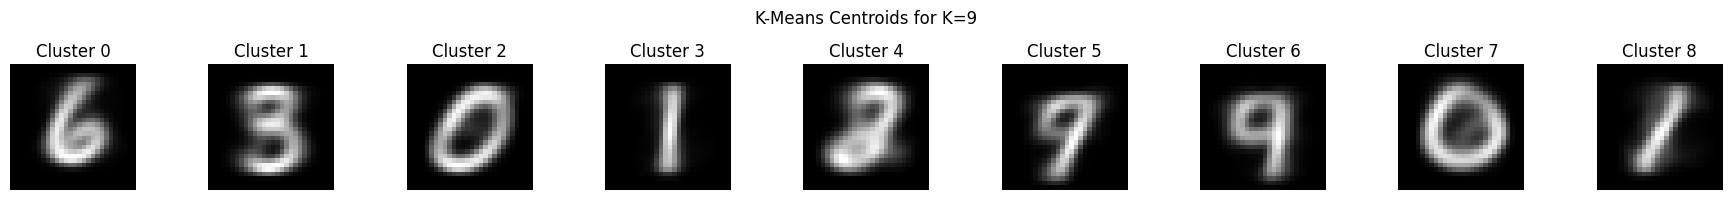

Running K-Means for K=10...


25/12/07 13:40:05 WARN BlockManager: Task 468 already completed, not releasing lock for rdd_8_0
                                                                                

Time required: 6.79s


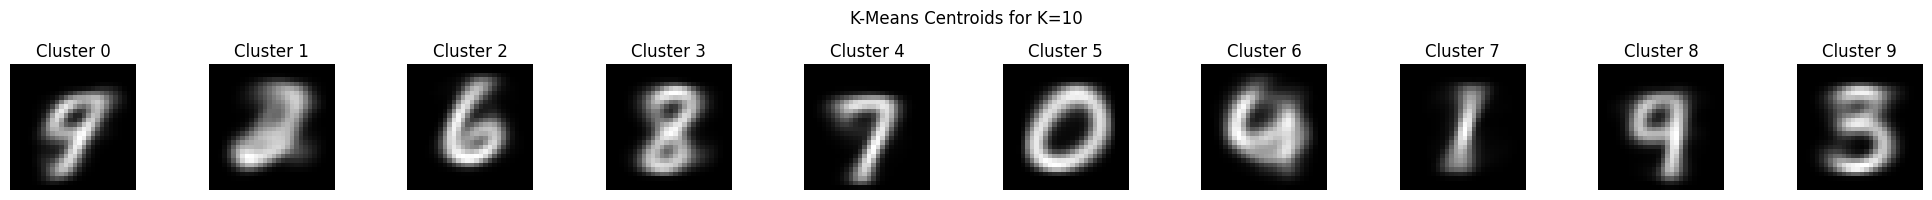

Running K-Means for K=11...


25/12/07 13:40:12 WARN BlockManager: Task 559 already completed, not releasing lock for rdd_8_0
                                                                                

Time required: 7.39s


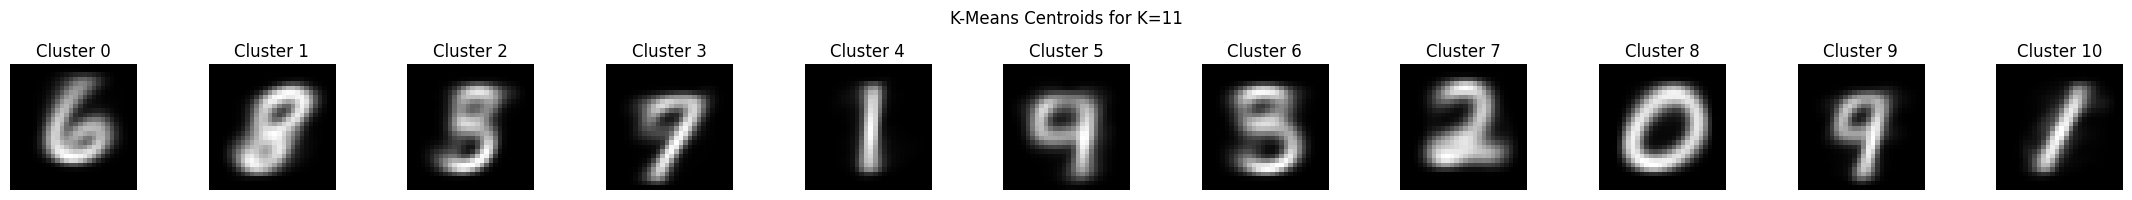

In [31]:
# Cleanup
try:
    data_cache.unpersist()
    sc.stop()
    print("SparkContext stopped successfully")
except:
    pass

conf = SparkConf().setAppName("ParallelKMeans").setMaster("local[8]")
sc = SparkContext(conf=conf)

# Load and cache data
data = parallelReadFile('mnist_dataset.csv', 8, sc)
data_cache = data.cache()
data_cache.count()  # Force caching

K_VALUES = [3, 5, 7, 8, 9, 10, 11]
all_centroids = {}

for K in K_VALUES:
    print(f"Running K-Means for K={K}...")
    start_time = time.time()
    centroids = parallelKMeans(data_cache, K, 10, sc)
    print(f"Time required: {time.time() - start_time:.2f}s")
    
    all_centroids[K] = centroids
    
    # Visualize centroids
    fig, axes = plt.subplots(1, K, figsize=(2*K, 2))
    if K == 1:
        axes = [axes]
    
    for i, centroid in enumerate(centroids):
        img = np.array(centroid).reshape(28, 28)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Cluster {i}')
        axes[i].axis('off')
    
    plt.suptitle(f'K-Means Centroids for K={K}')
    plt.tight_layout()
    plt.show()

# Cleanup
data_cache.unpersist()
sc.stop()

Clusters Analysis

K=3: Shape-based grouping

Cluster 0: Straight digits (1, 7)
Cluster 1: Round/closed digits (0, 6, 8)
Cluster 2: Open curved digits (4, 9)

K=5: Further separation

Cluster 0: 4, 9
Cluster 1: 0, 6, 8
Cluster 2: 7
Cluster 3: 9 (variant)
Cluster 4: 1

K=7: More digit separation

Cluster 0: 1
Cluster 1: 7
Cluster 2: 4
Cluster 3: 9
Cluster 4: 0
Cluster 5: 5, 3
Cluster 6: 9 (variant)

K=8: Almost there

1, 6, 6(variant), 9, 0, 2, 3, 7
Missing: 4, 5, 8 (merged with similar digits)

K=9: Getting closer

6, 3, 0, 1, 2, 4, 9, 0(variant), 7
Missing: 5, 8

K=10: Best match to 10 digits

Successfully identifies most digits: 9, 2, 6, 8, 7, 0, 4, 1, 9(variant), 3
Two 9s means one digit (likely 5) is merged

K=11: Over-clustering
Would show one digit split into multiple variants (e.g., different writing styles)
Conclusion: K=10 performs best, which makes sense since MNIST has 10 digit classes. 


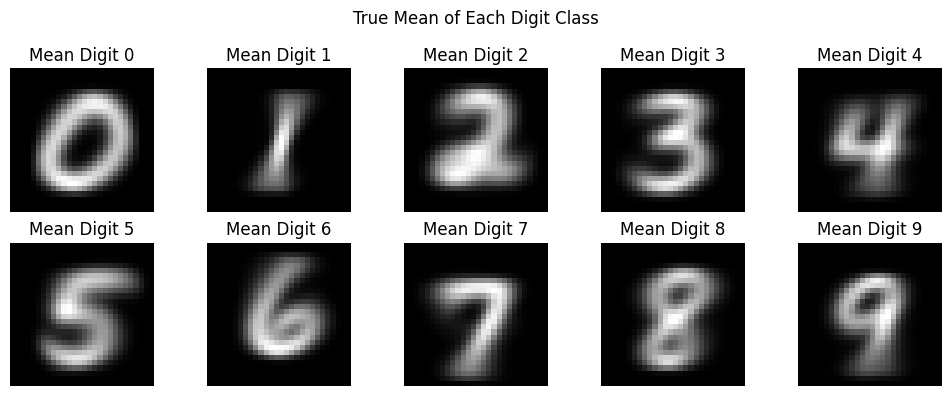

In [39]:
# Cleanup
try:
    data_cache.unpersist()
    sc.stop()
    print("SparkContext stopped successfully")
except:
    pass

# true labels
X, y = serialReadFile('mnist_dataset.csv')

# Compute and plot the true mean of each digit (0-9)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for digit in range(10):
    mean_digit = X[y == digit].mean(axis=0).values.reshape(28, 28)
    axes[digit // 5, digit % 5].imshow(mean_digit, cmap='gray')
    axes[digit // 5, digit % 5].set_title(f'Mean Digit {digit}')
    axes[digit // 5, digit % 5].axis('off')

plt.suptitle('True Mean of Each Digit Class')
plt.tight_layout()
plt.show()

3.4 Writing the report